In [2]:
import pandas as pd
import re
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load data

In [3]:
def camelcase_columns(df):
    df.columns = [re.sub( r'(\n)?(\s)+', ' ', c).strip().lower().replace(' ','_').replace('£','p') for c in df.columns]
    return df

In [4]:
def prepare_data(path_2017, path_2018):
    # load datasets
    season_18_df = pd.read_csv(path_2017)
    season_17_df = pd.read_excel(path_2018)
    # make column names consistent, and camelcase
    season_18_df = camelcase_columns(season_18_df)
    season_17_df = camelcase_columns(season_17_df)
    # add season numbers
    season_17_df['season'] = 2017
    season_18_df['season'] = 2018
    # append
    combined_df= season_17_df.append(season_18_df,sort=False)
    # add player id, and coerce value from string to numeric
    combined_df['player_id'] = combined_df.name + '-' + combined_df.position
    combined_df['p_value'] = pd.to_numeric(combined_df.p_value.str.replace('£',''))
    
    return combined_df

In [5]:
combined_df = prepare_data(path_2017='../data/2018_19_current_season_data.csv',
                          path_2018='../data/FPL-201718-player-stats.xlsx')

In [6]:
both_season_players = (set(combined_df.loc[combined_df.season==2018,'player_id'])
                        .intersection(set(combined_df.loc[combined_df.season==2017,'player_id'])))

### Fit basic timeseries model for each player 
fit using 2017 data - for now no covariates

storing prediction - mean forecast for first 10 games of next season

In [11]:
def fit_autoarima(data, player_id, plot_model = False, n_periods=10):
    train = data.loc[(data.player_id == player_id) &
                     (data.season == 2017),'pts']


    # Fit a simple auto_arima model
    modl = pm.auto_arima(train,seasonal=False,
                         stepwise=True, suppress_warnings=True, D=10, max_D=10,
                         error_action='ignore')
    
    
    # Create predictions for the future, evaluate on test
    preds, conf_int = modl.predict(n_periods=n_periods, return_conf_int=True)
    
    if plot_model:
        test = data.loc[(data.player_id == player_id) &
                 (data.season == 2018) &
                 (data.gw_gameweek < 11),'pts']
        
        
        print(f"Test RMSE: {player_id} %.3f" % np.sqrt(mean_squared_error(test, preds)))

        train_idx = np.arange(1,train.shape[0]+1)
        test_idx = np.arange(train.shape[0]+1,test.shape[0]+train.shape[0]+1)

        plt.plot(train_idx, train, alpha=0.75)
        plt.plot(test_idx, preds, alpha=0.75)  # Forecasts
        plt.scatter(test_idx, test,
                    alpha=0.4, marker='x')  # Test data
        plt.fill_between(test_idx,
                         conf_int[:, 0], conf_int[:, 1],
                         alpha=0.1, color='b')
        plt.title(f"Points forecast - {player_id}")
        plt.xlabel("Gameweek")
        plt.show()
    return preds.mean()

In [12]:
def fit_all_models(both_season_players):
    models = {'player_id':[],
             'prediction_ts':[]}
    for i,p in enumerate(both_season_players):
        try:
            models['prediction_ts'].append(fit_autoarima(combined_df, p))
            models['player_id'].append(p) 
        except:
            print(f'player {p} failed')
    predictions = pd.DataFrame(models)
    print('top predictions')
    print(predictions.sort_values(by='prediction_ts',ascending=False).head())
    return predictions

In [13]:
predictions = fit_all_models(both_season_players)

/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/au

top predictions
           player_id  prediction_ts
192  van Aanholt-DEF      17.301803
267        Salah-MID       7.973684
312  Milivojevic-MID       6.829412
4          Pérez-FWD       6.530504
226    Robertson-DEF       6.081683


### Merge predictions with prices

also add previous season points

In [22]:
def prepare_candidate_df(data, predictions):
    prev_points = combined_df.loc[combined_df.season==2017].groupby('player_id')[['pts']].sum().reset_index().rename(columns={'pts':'prediction_prev'})
    prev_points.prediction_prev /= 38
    
    candidates = (data.loc[(data.gw_gameweek==1)&
                   (data.season == 2018),
                     ['player_id','p_value','team', 'position']]
            .drop_duplicates(['player_id'])
    .merge(predictions,on='player_id',how='inner')
    .merge(prev_points,on='player_id',how='inner')
            .sort_values(by='prediction_ts',ascending=False))
    return candidates.loc[candidates.prediction_ts.notna()].reset_index(drop=True)

In [23]:
candidates = prepare_candidate_df(combined_df,predictions)

### Show characteristics of top *n* candidates

quite jokes that van Aanholt is so high - some sensible names here though

In [31]:
def show_top_candidates(candidates, n = 20):
    print('time series candidates')
    print(candidates.sort_values(by='prediction_ts',ascending=False).drop(columns=['prediction_prev']).head(n))
    sns.scatterplot(data=candidates,x='p_value',y='prediction_ts',hue='position')
    plt.show()
    
    for p in candidates.head(n).player_id:
        fit_autoarima(combined_df, p, plot_model=True)
    
    print('season total candidates')
    print(candidates.sort_values(by='prediction_prev',ascending=False).drop(columns=['prediction_ts']).head(n))

    sns.scatterplot(data=candidates,x='p_value',y='prediction_prev',hue='position')
    plt.show()


time series candidates
               player_id  p_value team position  prediction_ts
0        van Aanholt-DEF      5.5  CRY      DEF      17.301803
1              Salah-MID     13.0  LIV      MID       7.973684
2        Milivojevic-MID      6.5  CRY      MID       6.829412
3              Pérez-FWD      6.5  NEW      FWD       6.530504
4          Robertson-DEF      6.0  LIV      DEF       6.081683
5           Sterling-MID     11.0  MCI      MID       6.026316
6            Tomkins-DEF      4.5  CRY      DEF       6.012381
7               Kane-FWD     12.5  TOT      FWD       5.754370
8          De Bruyne-MID     10.0  MCI      MID       5.500000
9            Eriksen-MID      9.5  TOT      MID       5.236842
10            Mahrez-MID      9.0  MCI      MID       5.131579
11  Alexander-Arnold-DEF      5.0  LIV      DEF       4.919305
12           Lejeune-DEF      4.5  NEW      DEF       4.883526
13             Vardy-FWD      9.0  LEI      FWD       4.815789
14            Rondón-FWD      6.

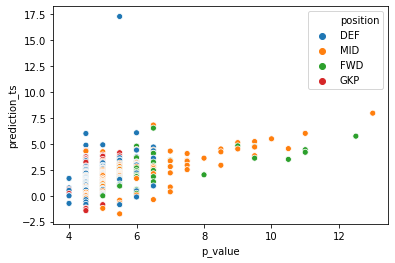

Test RMSE: van Aanholt-DEF 14.279


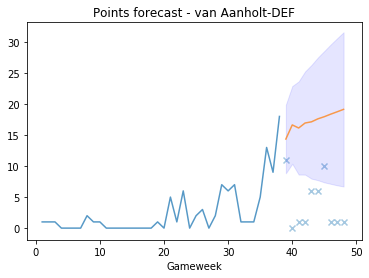

Test RMSE: Salah-MID 4.269


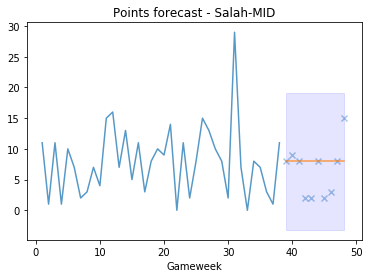

Test RMSE: Milivojevic-MID 5.284


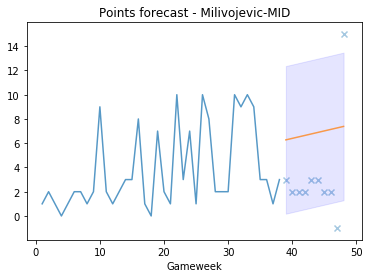

Test RMSE: Pérez-FWD 4.484


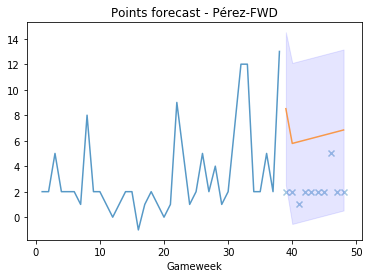

Test RMSE: Robertson-DEF 3.570


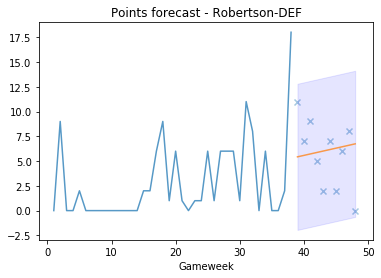

Test RMSE: Sterling-MID 4.269


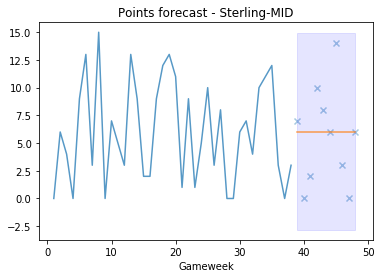

Test RMSE: Tomkins-DEF 4.477


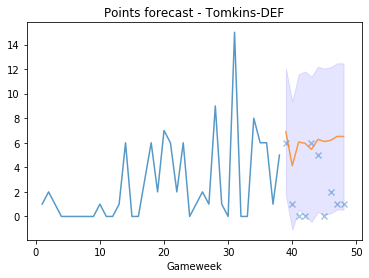

Test RMSE: Kane-FWD 4.332


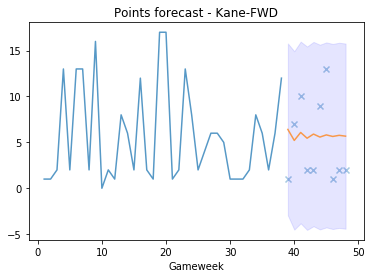

Test RMSE: De Bruyne-MID 5.315


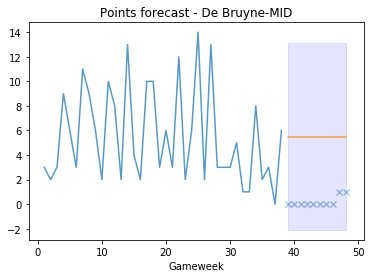

Test RMSE: Eriksen-MID 3.651


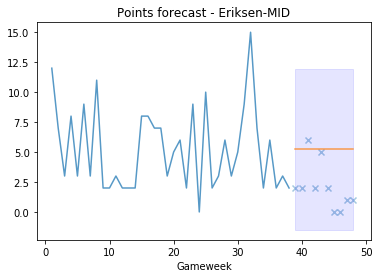

Test RMSE: Mahrez-MID 4.664


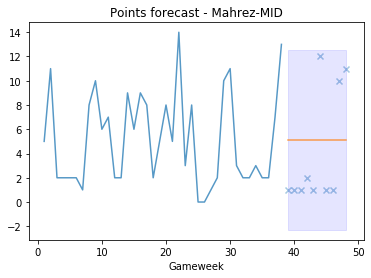

Test RMSE: Alexander-Arnold-DEF 3.532


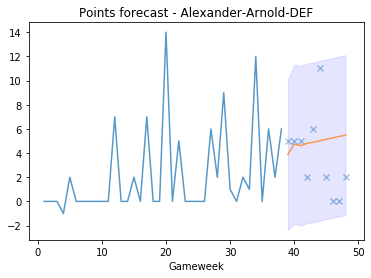

Test RMSE: Lejeune-DEF 4.914


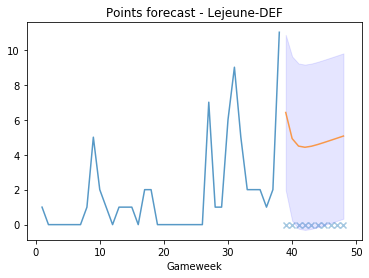

Test RMSE: Vardy-FWD 4.103


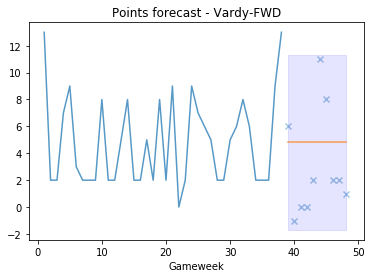

Test RMSE: Rondón-FWD 4.103


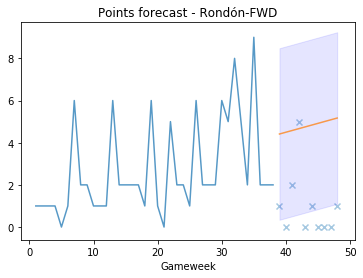

Test RMSE: Firmino-FWD 2.746


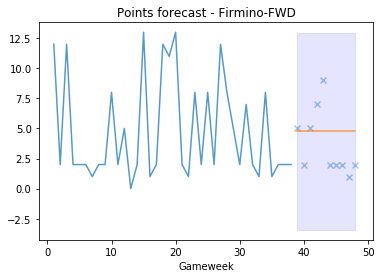

Test RMSE: Sané-MID 3.364


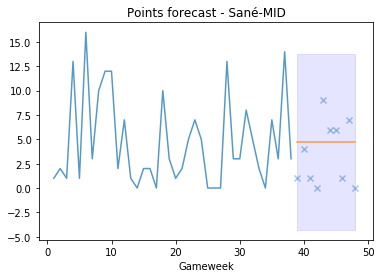

Test RMSE: Azpilicueta-DEF 2.115


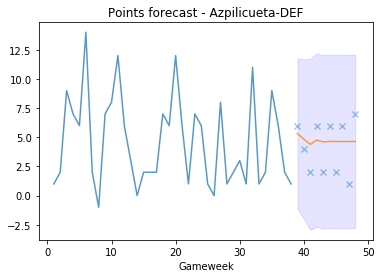

Test RMSE: Hazard-MID 6.689


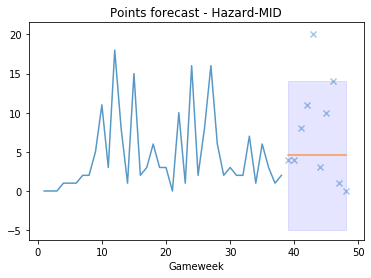

Test RMSE: Alli-MID 3.866


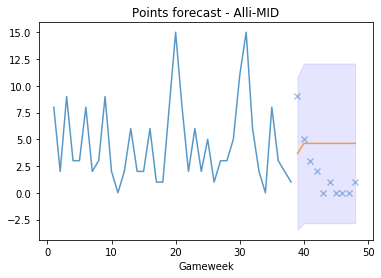

season total candidates
          player_id  p_value team position  prediction_prev
1         Salah-MID     13.0  LIV      MID         7.973684
5      Sterling-MID     11.0  MCI      MID         6.026316
7          Kane-FWD     12.5  TOT      FWD         5.710526
8     De Bruyne-MID     10.0  MCI      MID         5.500000
9       Eriksen-MID      9.5  TOT      MID         5.236842
10       Mahrez-MID      9.0  MCI      MID         5.131579
13        Vardy-FWD      9.0  LEI      FWD         4.815789
15      Firmino-FWD      9.5  LIV      FWD         4.763158
16         Sané-MID      9.5  MCI      MID         4.710526
20          Son-MID      8.5  TOT      MID         4.684211
17  Azpilicueta-DEF      6.5  CHE      DEF         4.605263
19         Alli-MID      9.0  TOT      MID         4.605263
18       Hazard-MID     10.5  CHE      MID         4.552632
22       Agüero-FWD     11.0  MCI      FWD         4.447368
30  David Silva-MID      8.5  MCI      MID         4.447368
26       Alonso-

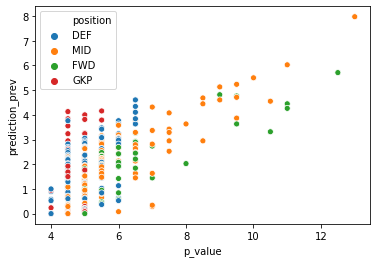

In [32]:
show_top_candidates(candidates)

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

In [35]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.p_value))
    gk = dict(zip(player_ids,(data.position == 'GKP').astype(int)))
    defe = dict(zip(player_ids,(data.position == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.position == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.position == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 100.0, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) == 3, "Less than 3 STR"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [38]:
_, _, selections_ts = select_best_15(candidates,'prediction_ts')

In [40]:
_, _, selections_prev_total = select_best_15(candidates,'prediction_prev')

In [39]:
selected_players_ts = candidates.iloc[selections_ts]; selected_players_ts

,player_id,p_value,team,position,prediction_ts,prediction_prev
0,van Aanholt-DEF,5.5,CRY,DEF,17.301803,2.500000
1,Salah-MID,13.0,LIV,MID,7.973684,7.973684
11,Alexander-Arnold-DEF,5.0,LIV,DEF,4.919305,2.184211
12,Lejeune-DEF,4.5,NEW,DEF,4.883526,1.736842
14,Rondón-FWD,6.0,NEW,FWD,4.791279,2.710526
2,Milivojevic-MID,6.5,CRY,MID,6.829412,3.789474
25,McCarthy-GKP,4.5,SOU,GKP,4.380676,1.368421
28,Westwood-MID,4.5,BUR,MID,4.308236,0.921053
29,Kenedy-MID,5.0,NEW,MID,4.251391,1.342105
3,Pérez-FWD,6.5,NEW,FWD,6.530504,3.263158


In [21]:
selected_players.position.value_counts()

MID    5
DEF    5
FWD    3
GKP    2
Name: position, dtype: int64

In [22]:
selected_players.p_value.sum()

100.0

In [23]:
selected_players.prediction.sum()

93.98788336577455